## Name: Luke Nelson
## Student ID: 5281493709

# <center> Homework 4 </center>

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import model_selection
import xgboost as xgb
import sys
from impyute.imputation.cs import fast_knn
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

import weka.core.jvm as jvm
from weka.classifiers import Classifier, Evaluation
from weka.core.classes import Random
import weka.core.converters as conv
import weka.plot.classifiers as plcls
from sklearn.model_selection import StratifiedKFold

### 1. The LASSO and BOOSTING for Regression
### (a) Download the Communities and Crime data. Use the first 1495 rows of data as the training set and the rest as the test set.

In [23]:
fileDir = os.path.dirname(os.path.realpath('__file__'))
filename = os.path.join(fileDir, '../data/communities.csv')
filename = os.path.abspath(os.path.realpath(filename))
df=pd.read_csv(filename, header=None)   #Read in the .csv file
df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


In [24]:
#Get column headers
filename2 = os.path.join(fileDir, '../data/communities.txt')
info = open(filename2)
headers=list()
for line in info:
    line=line.rstrip()
    if re.search('^@attribute', line):
        x=line.split()
        headers.append(x[1])

#Add column headers to the df
df.columns=headers
df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


In [25]:
train=df.iloc[:1495]
train_X=train.iloc[:,:-1]
train_Y=train.iloc[:,-1]
train.head()
train.shape

(1495, 128)

In [26]:
test=df.iloc[1495:]
test_X=test.iloc[:,:-1]
test_Y=test.iloc[:,-1]
test.head()
test.shape

(499, 128)

### (b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [27]:

#this allows us to see what columsn has missing values: print(df.isnull().sum())
#Excluding the non-predictive columns, replace all ? with nan
train_X.iloc[:,5:]=train_X.iloc[:,5:].replace(to_replace='?',value=np.nan)
train_X.iloc[:,5:]=train_X.iloc[:,5:].astype(np.float64)

#Using df method to replace NA values with median of test df

saved_med=train_X.median()
train_X=train_X.fillna(train_X.median())

#Replace NA values in the test set with median values fro the train
test_X.iloc[:,5:]=test_X.iloc[:,5:].replace(to_replace='?',value=np.nan)
test_X.iloc[:,5:]=test_X.iloc[:,5:].astype(np.float64)
test_X=test_X.fillna(saved_med)

#### I utilized the median of each column to fill the missing values in each column (I was sure to skip the first 5 non-predictive columns)

### (c) Plot a correlation matrix for the features in the data set.

In [28]:
corrMatrix = train_X.corr()
print (corrMatrix)

                         state      fold  population  householdsize  \
state                 1.000000 -0.014090   -0.056895      -0.059016   
fold                 -0.014090  1.000000   -0.006670       0.040634   
population           -0.056895 -0.006670    1.000000      -0.040404   
householdsize        -0.059016  0.040634   -0.040404       1.000000   
racepctblack         -0.039104  0.008585    0.242144      -0.068374   
racePctWhite          0.215112 -0.016408   -0.306023      -0.243565   
racePctAsian         -0.313357 -0.002880    0.168868       0.209848   
racePctHisp          -0.214741  0.011776    0.162282       0.473320   
agePct12t21           0.095514 -0.022575    0.014554       0.517742   
agePct12t29           0.041642 -0.014108    0.128721       0.371658   
agePct16t24           0.056167 -0.022694    0.075744       0.301949   
agePct65up            0.015729 -0.034821   -0.107060      -0.606714   
numbUrban            -0.063333 -0.001950    0.993613      -0.041553   
pctUrb

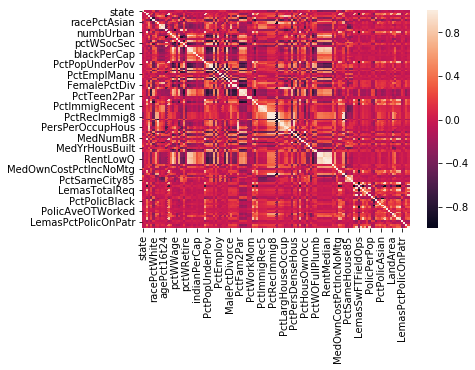

In [29]:
#Seaborn heatmap
ax = sns.heatmap(corrMatrix)

### (d) Calculate the Coefficient of Variantion CV for each feature, where CV=s/m, in which s is sample standard deviation and m is sample mean.

In [33]:
cv=train_X.std(axis=0)/train_X.mean(axis=0)
cv

state                   0.574958
fold                    0.510302
population              2.241105
householdsize           0.355800
racepctblack            1.428885
racePctWhite            0.330213
racePctAsian            1.359100
racePctHisp             1.612091
agePct12t21             0.369083
agePct12t29             0.291315
agePct16t24             0.500310
agePct65up              0.412776
numbUrban               2.038461
pctUrban                0.643318
medIncome               0.591978
pctWWage                0.328614
pctWFarmSelf            0.701898
pctWInvInc              0.365335
pctWSocSec              0.360715
pctWPubAsst             0.706206
pctWRetire              0.345421
medFamInc               0.540670
perCapInc               0.558079
whitePerCap             0.519828
blackPerCap             0.599341
indianPerCap            0.818368
AsianPerCap             0.614866
OtherPerCap             0.673279
HispPerCap              0.484068
NumUnderPov             2.342443
          

### (e) Pick floor(sqrt(128)) features with highest CV, and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

In [34]:
#We need to show the 11 features with the highest cv
top_cv=cv.nlargest(11)
top_cv

PctPolicAsian          5.527059
NumStreet              4.292923
NumInShelters          3.470952
NumIlleg               3.058964
NumImmig               2.926635
LemasPctOfficDrugUn    2.552946
NumUnderPov            2.342443
LemasSwornFT           2.248042
population             2.241105
numbUrban              2.038461
HousVacant             1.968467
dtype: float64

In [35]:
#Get the index values from top cv
top_cv_ind=list(top_cv.index.values)
plots_df=train_X.loc[:,top_cv_ind]
plots_df.head()

,PctPolicAsian,NumStreet,NumInShelters,NumIlleg,NumImmig,LemasPctOfficDrugUn,NumUnderPov,LemasSwornFT,population,numbUrban,HousVacant
0,0.1,0.0,0.04,0.04,0.03,0.32,0.08,0.03,0.19,0.20,0.21
1,0.0,0.0,0.00,0.00,0.01,0.00,0.01,0.02,0.00,0.02,0.02
2,0.0,0.0,0.00,0.01,0.00,0.00,0.01,0.02,0.00,0.00,0.01
3,0.0,0.0,0.00,0.03,0.02,0.00,0.01,0.02,0.04,0.06,0.01
4,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.02,0.01


Text(0.5,1,'PctPolicAsian')

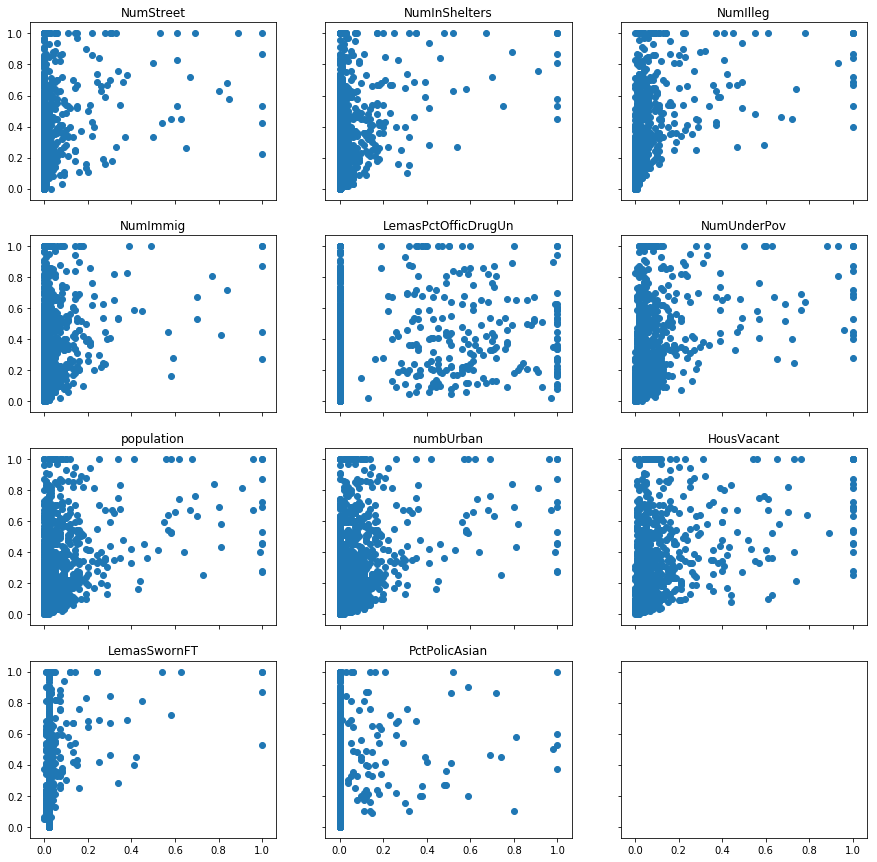

In [12]:
#Scatter Plots
fig, ax = plt.subplots(4, 3, sharex='col', sharey='row', figsize=(15,15))
ax[0,0].scatter(plots_df['NumStreet'],train_Y)
ax[0, 0].set_title('NumStreet')
ax[0,1].scatter(plots_df['NumInShelters'],train_Y)
ax[0, 1].set_title('NumInShelters')
ax[0,2].scatter(plots_df['NumIlleg'],train_Y)
ax[0, 2].set_title('NumIlleg')
ax[1,0].scatter(plots_df['NumImmig'],train_Y)
ax[1, 0].set_title('NumImmig')
ax[1,1].scatter(plots_df['LemasPctOfficDrugUn'],train_Y)
ax[1, 1].set_title('LemasPctOfficDrugUn')
ax[1,2].scatter(plots_df['NumUnderPov'],train_Y)
ax[1, 2].set_title('NumUnderPov')
ax[2,0].scatter(plots_df['population'],train_Y)
ax[2, 0].set_title('population')
ax[2,1].scatter(plots_df['numbUrban'],train_Y)
ax[2, 1].set_title('numbUrban')
ax[2,2].scatter(plots_df['HousVacant'],train_Y)
ax[2, 2].set_title('HousVacant')
ax[3,0].scatter(plots_df['LemasSwornFT'],train_Y)
ax[3, 0].set_title('LemasSwornFT')
ax[3,1].scatter(plots_df['PctPolicAsian'],train_Y)
ax[3, 1].set_title('PctPolicAsian')

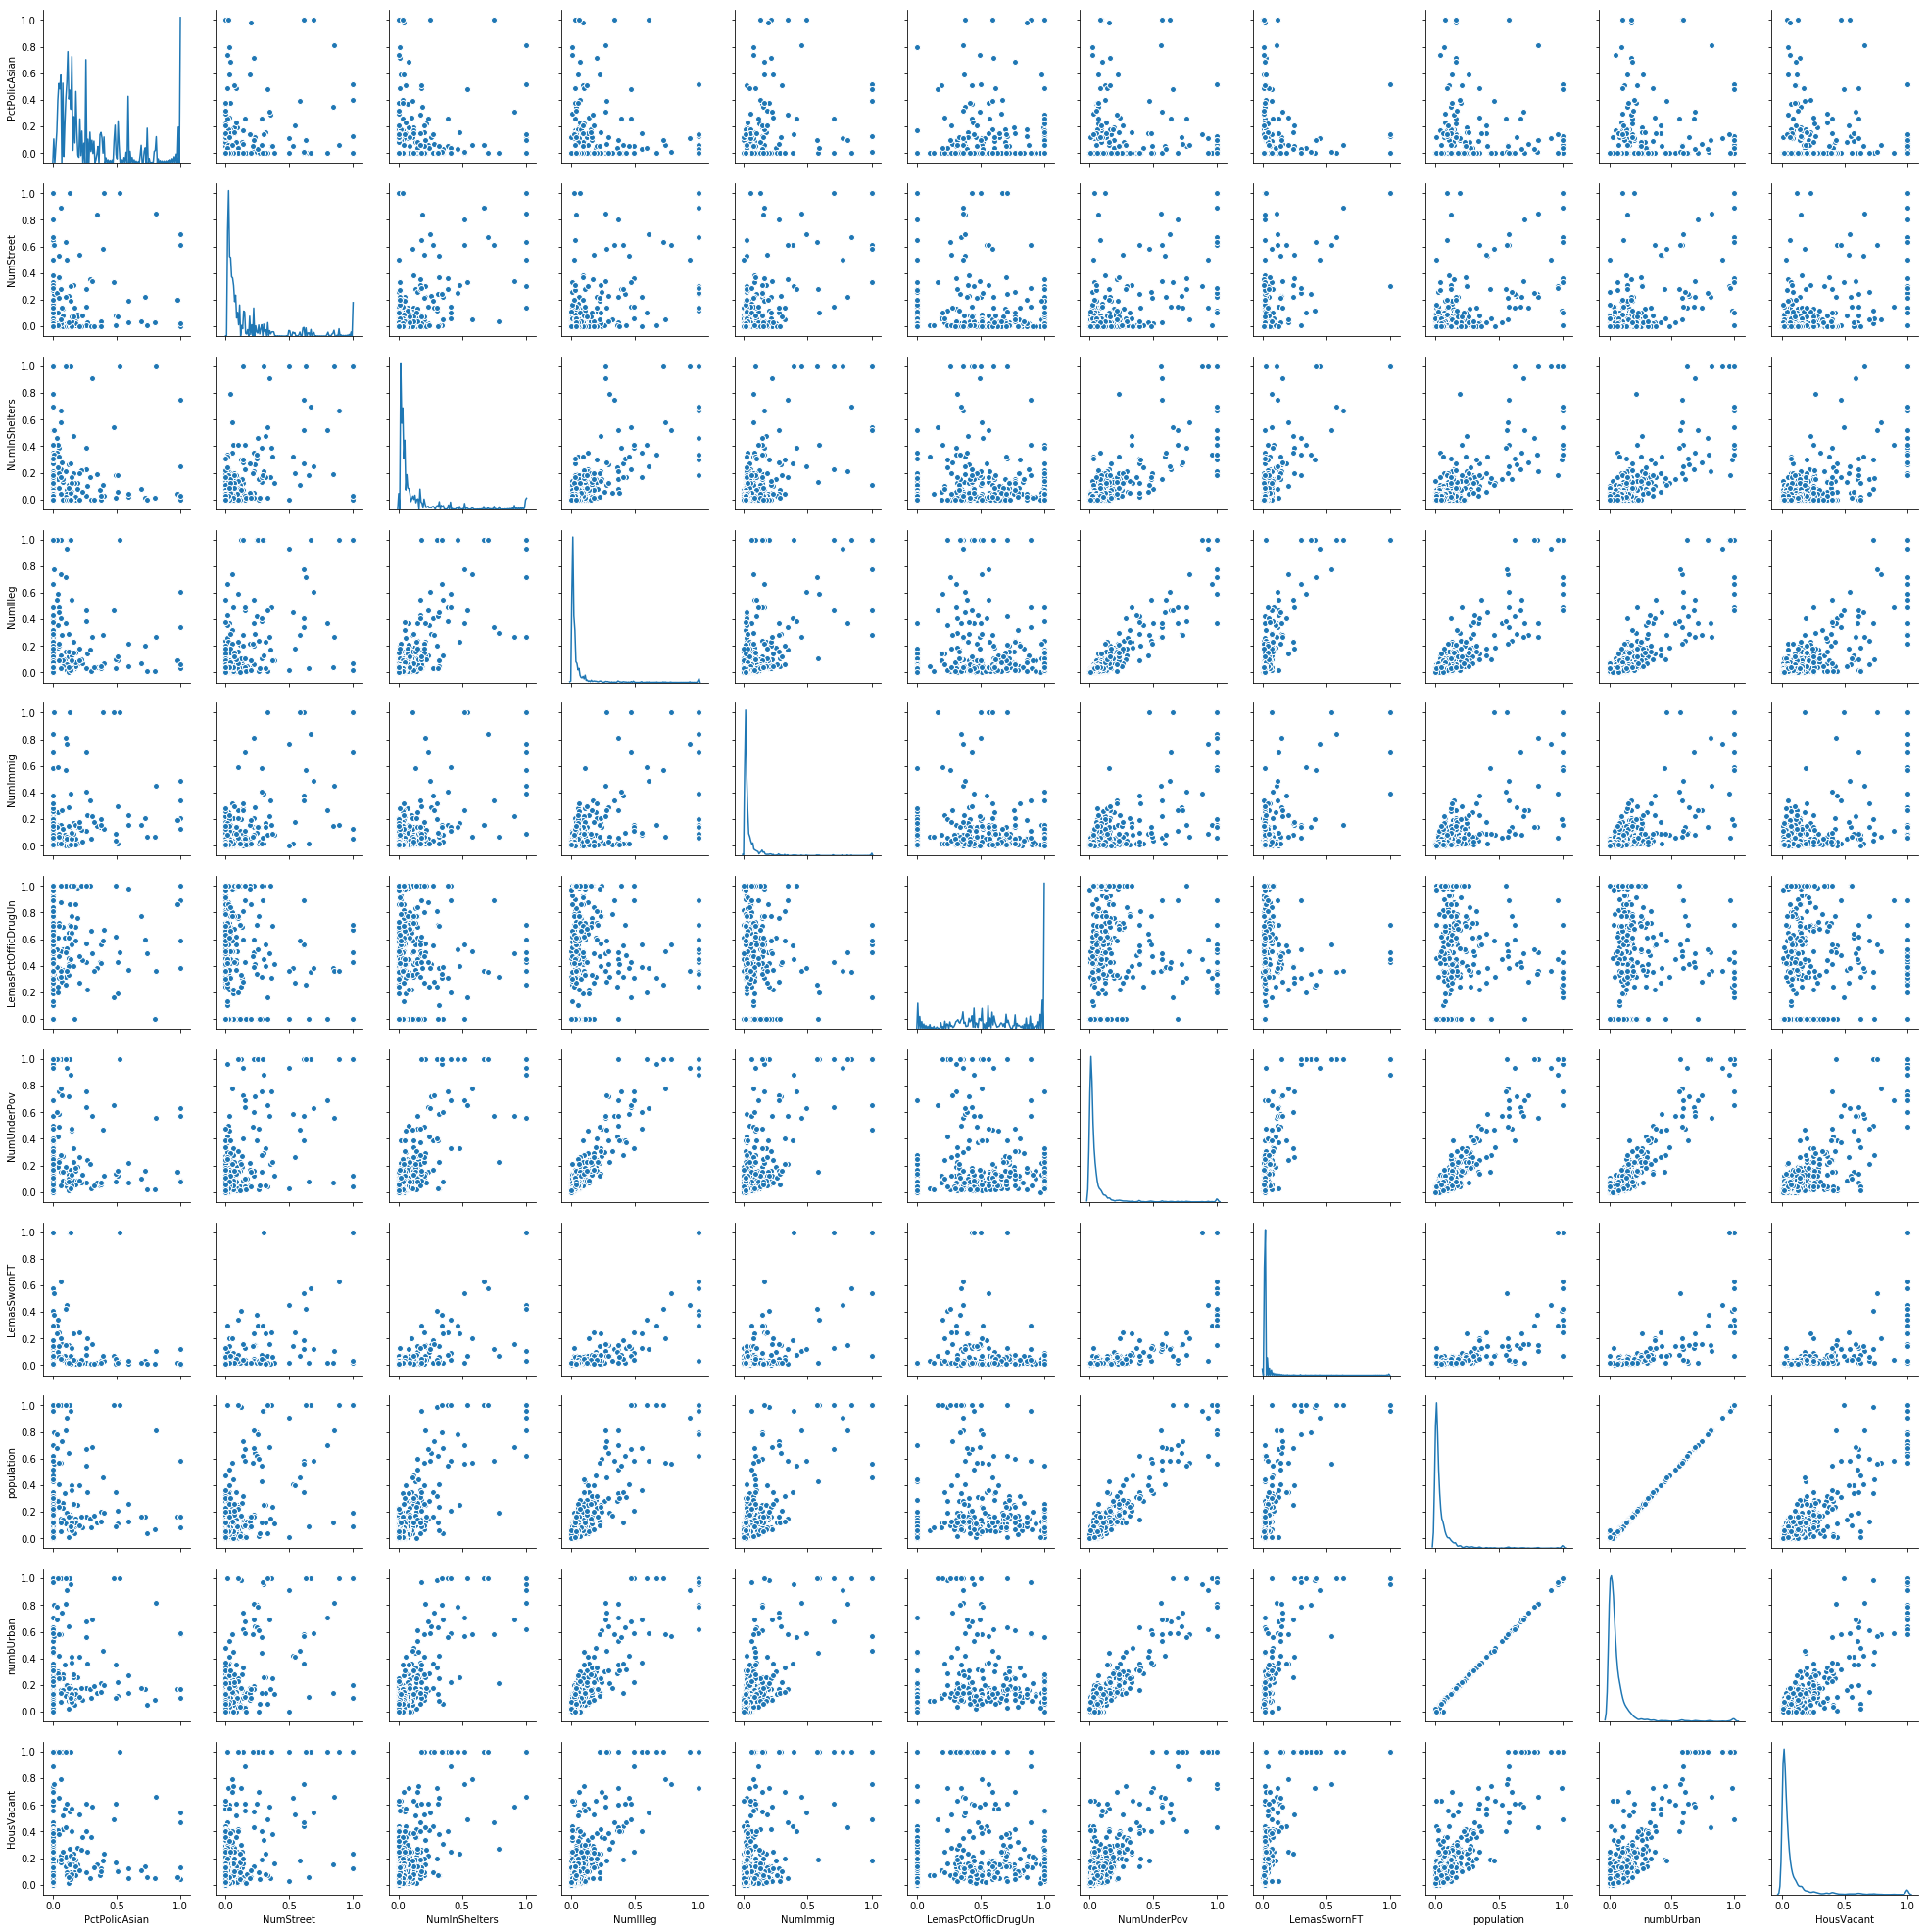

In [37]:
#Pairplots
p = sns.pairplot(plots_df,
                diag_kind='kde',
                 palette='dark')

Text(0.5,1,'PctPolicAsian')

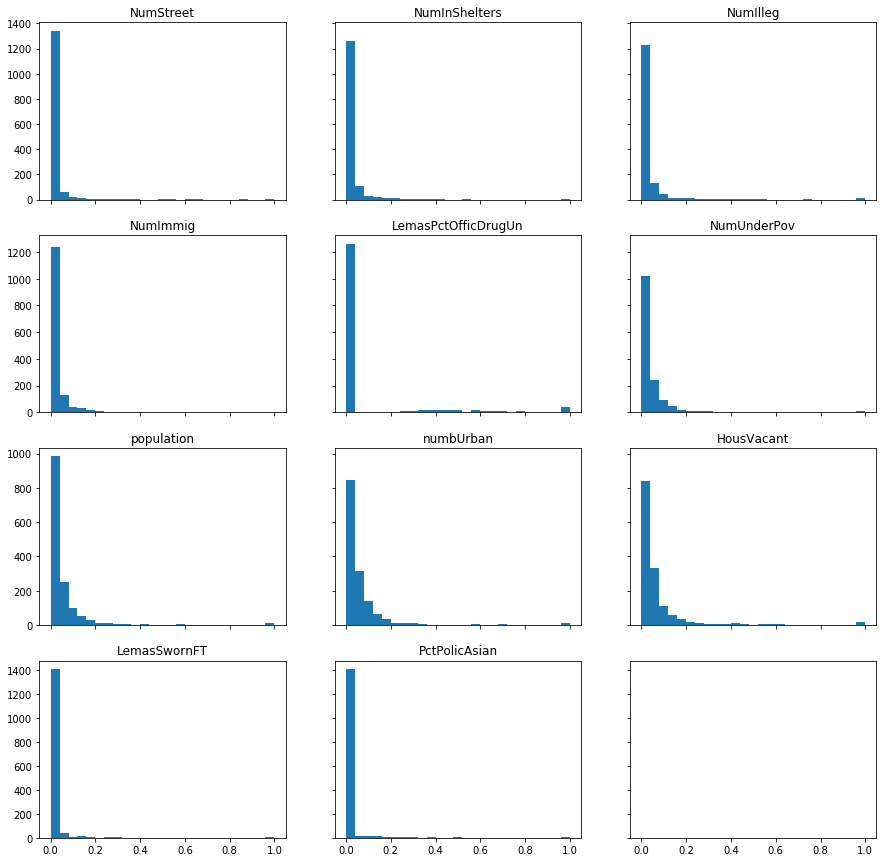

In [13]:
#Historgrams
n_bins=25
fig, ax = plt.subplots(4, 3, sharex='col', sharey='row', figsize=(15,15))
ax[0,0].hist(plots_df['NumStreet'],bins=n_bins)
ax[0, 0].set_title('NumStreet')
ax[0,1].hist(plots_df['NumInShelters'],bins=n_bins)
ax[0, 1].set_title('NumInShelters')
ax[0,2].hist(plots_df['NumIlleg'],bins=n_bins)
ax[0, 2].set_title('NumIlleg')
ax[1,0].hist(plots_df['NumImmig'],bins=n_bins)
ax[1, 0].set_title('NumImmig')
ax[1,1].hist(plots_df['LemasPctOfficDrugUn'],bins=n_bins)
ax[1, 1].set_title('LemasPctOfficDrugUn')
ax[1,2].hist(plots_df['NumUnderPov'],bins=n_bins)
ax[1, 2].set_title('NumUnderPov')
ax[2,0].hist(plots_df['population'],bins=n_bins)
ax[2, 0].set_title('population')
ax[2,1].hist(plots_df['numbUrban'],bins=n_bins)
ax[2, 1].set_title('numbUrban')
ax[2,2].hist(plots_df['HousVacant'],bins=n_bins)
ax[2, 2].set_title('HousVacant')
ax[3,0].hist(plots_df['LemasSwornFT'],bins=n_bins)
ax[3, 0].set_title('LemasSwornFT')
ax[3,1].hist(plots_df['PctPolicAsian'],bins=n_bins)
ax[3, 1].set_title('PctPolicAsian')



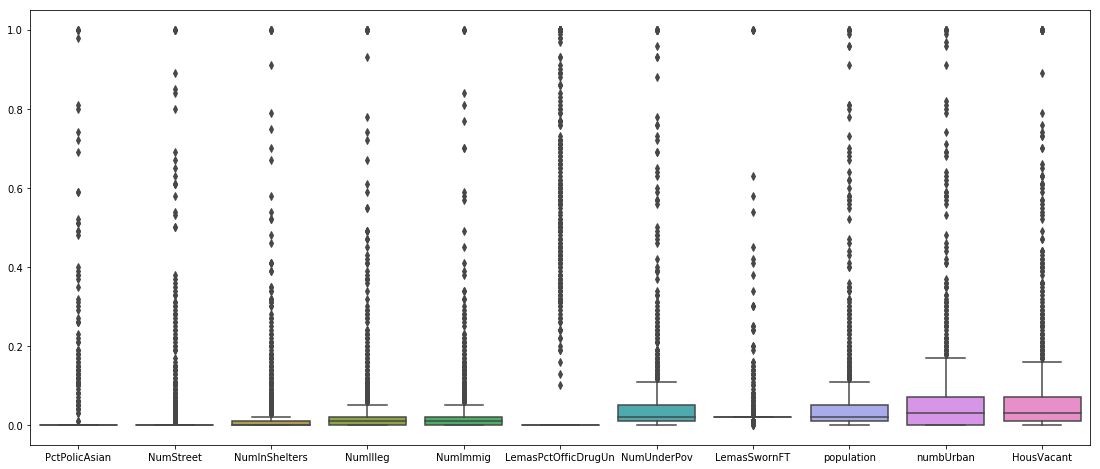

In [14]:
plt.figure(figsize=(19,8))
sns.boxplot(data=plots_df.iloc[:,:])


#### No, it is difficult to draw conclusions about significance of the features simply by scatterplot. There does not appear to be strong relationships between the predictors and the goal variable when simply visualizing the relationships. There do appear to be a number of outliers according to the boxplots.

### (f) Fit a linear model using least squares to the training set and report the test error.

In [15]:
#Use statsmodels for this
train_Y=np.asarray(train_Y)
linear_regress = smf.OLS(train_Y.astype(float),train_X.iloc[:,5:].astype(float)).fit()
linear_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     68.33
Date:                Thu, 02 Jul 2020   Prob (F-statistic):               0.00
Time:                        09:40:42   Log-Likelihood:                 956.02
No. Observations:                1495   AIC:                            -1670.
Df Residuals:                    1374   BIC:                            -1028.
Df Model:                         121                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
population                0.0037      0.476      0.008      0.994      -0.930       0.938
householdsize            -0.0148      0.098     -0.151      0.880      -0.206       0.177
racepctblack              0.2770      0.060      4.624      0.000       0.159       0.395
racePctWhite              0.0062      0.067      0.093      0.926      -0.125       0.137
racePctAsian             -0.0278      0.041     -0.673      0.501      -0.109       0.053
racePctHisp               0.0086      0.065      0.132      0.895      -0.119       0.137
agePct12t21               0.1881      0.129      1.461      0.144      -0.064       0.441
agePct12t29              -0.3310      0.184     -1.797      0.073      -0.692       0.030
agePct16t24              -0.1409      0.196     -0.717      0.473      -0.526       0.244
agePct65up                0.0634      0.124      0.513      0.608      -0.179       0.306
numbUrban                -0.1407      0.464     -0.303      0.762      -1.052       0.770
pctUrban                  0.0489      0.019      2.611      0.009       0.012       0.086
medIncome                -0.1721      0.202     -0.852      0.394      -0.568       0.224
pctWWage                 -0.1326      0.107     -1.242      0.214      -0.342       0.077
pctWFarmSelf              0.0461      0.023      1.966      0.049       0.000       0.092
pctWInvInc               -0.2026      0.081     -2.506      0.012      -0.361      -0.044
pctWSocSec                0.1450      0.125      1.160      0.246      -0.100       0.390
pctWPubAsst               0.0624      0.054      1.153      0.249      -0.044       0.169
pctWRetire               -0.1229      0.044     -2.763      0.006      -0.210      -0.036
medFamInc                 0.2968      0.188      1.577      0.115      -0.072       0.666
perCapInc                -0.0504      0.222     -0.227      0.820      -0.485       0.384
whitePerCap              -0.1863      0.179     -1.040      0.298      -0.538       0.165
blackPerCap              -0.0396      0.030     -1.343      0.180      -0.098       0.018
indianPerCap             -0.0426      0.023     -1.871      0.061      -0.087       0.002
AsianPerCap               0.0299      0.022      1.372      0.170      -0.013       0.073
OtherPerCap               0.0304      0.022      1.368      0.172      -0.013       0.074
HispPerCap                0.0322      0.029      1.124      0.261      -0.024       0.088
NumUnderPov               0.0900      0.192      0.470      0.639      -0.286       0.466
PctPopUnderPov           -0.2026      0.074     -2.733      0.006      -0.348      -0.057
PctLess9thGrade          -0.0576      0.079     -0.733      0.464      -0.212       0.096
PctNotHSGrad              0.0282      0.111      0.254      0.800      -0.190       0.246
PctBSorMore            

In [16]:
test_pred=linear_regress.predict(test_X.iloc[:,5:].astype(float))
test_MSE=metrics.mean_squared_error(test_Y, test_pred)
print('Test MSE:',test_MSE)

Test MSE: 0.018045805782227912


### (g) Fit a ridge regression model on the training set, with lambda chosen by cross-validation. Report the test error obtained.

In [17]:
#https://towardsdatascience.com/how-to-perform-lasso-and-ridge-regression-in-python-3b3b75541ad8
ridge=Ridge()
#lambd=np.logspace(-15,2,base=10,num=7,dtype='float')
lambd=[1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,5,10,20]
params={'alpha':list(lambd)}
ridge_regressor=GridSearchCV(ridge, params, scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(train_X.iloc[:,5:].astype(float), train_Y.astype(float))

/Users/lukenelson/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.925084054755249e-19 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/lukenelson/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.1327496735784495e-19 / 1.1102230246251565e-16
  RuntimeWarning)


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             scoring='neg_mean_squared_error')

In [18]:
#sorted(metrics.SCORERS.keys())
#Best alpha parameter
print('Best alpha parameter:', ridge_regressor.best_params_)

#Best MSE
print('CV MSE:', -1*ridge_regressor.best_score_)

Best alpha parameter: {'alpha': 5}
CV MSE: 0.01909573677062376


In [19]:
#Test MSE using these parameters
test_ridge = Ridge(alpha=5.0).fit(train_X.iloc[:,5:].astype(float), train_Y.astype(float))
test_pred=test_ridge.predict(test_X.iloc[:,5:].astype(float))
test_MSE=metrics.mean_squared_error(test_Y, test_pred)
print('Ridge Regression Test MSE:',test_MSE)

Ridge Regression Test MSE: 0.01743183558855509


### (h) Fit a LASSO model on the training set, with lambda chosen by cross-validation. Report the test error obtained along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

In [38]:
lasso=Lasso(tol=0.2)
lambd=[1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,5,10,20]
parameters={'alpha':list(lambd)}
lasso_regressor=GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error',cv=5)
lasso_regressor.fit(train_X.iloc[:,5:].astype(float), train_Y.astype(float))

#Best alpha parameter
print('Best alpha parameter:', lasso_regressor.best_params_)

#Best MSE
print('CV MSE:', -1*lasso_regressor.best_score_)

Best alpha parameter: {'alpha': 0.001}
CV MSE: 0.020209407330412082


In [39]:
coefficients=lasso_regressor.best_estimator_.coef_
cols=train_X.iloc[:,5:].columns

selected_vars={'Variables':cols, 'Non-Zero_Coefficients':coefficients}
selected_vars=pd.DataFrame(selected_vars)
selected_vars= selected_vars.loc[selected_vars['Non-Zero_Coefficients'] != 0]
print('Here is a list of the variables selected by the model:')
print(list(selected_vars.loc[:,'Variables'].values))

Here is a list of the variables selected by the model:
['population', 'racepctblack', 'racePctWhite', 'racePctHisp', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWInvInc', 'pctWPubAsst', 'pctWRetire', 'AsianPerCap', 'MalePctDivorce', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'PctIlleg', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'OwnOccMedVal', 'OwnOccHiQuart', 'RentMedian', 'RentHighQ', 'MedRentPctHousInc', 'MedOwnCostPctIncNoMtg', 'NumStreet', 'PctBornSameState', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn']


In [40]:
#Test MSE
test_lasso = Lasso(alpha=0.001).fit(train_X.iloc[:,5:].astype(float), train_Y.astype(float))
test_pred=test_lasso.predict(test_X.iloc[:,5:].astype(float))
test_MSE=metrics.mean_squared_error(test_Y, test_pred)
print('Lasso Test MSE:',test_MSE)

Lasso Test MSE: 0.017545410513550568


#### The same but we are standardizing the data:

In [41]:
#Repeating Lasso, but now with standardized features
#https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc
#Normalization typically means rescales the values into a range of [0,1]. Standardization typically means rescales data to have a mean of 0 and a standard deviation of 1 (unit variance).

names=train_X.iloc[:,5:].columns

# Create the Scaler object
scaler = preprocessing.StandardScaler()

# Fit your data on the scaler object
scaled_train_X = scaler.fit_transform(train_X.iloc[:,5:])
scaled_train_X = pd.DataFrame(scaled_train_X, columns=names)

#Same for test
names=test_X.iloc[:,5:].columns
scaled_test_X = scaler.transform(test_X.iloc[:,5:])
scaled_test_X = pd.DataFrame(scaled_test_X, columns=names)





In [42]:
lasso=Lasso(tol=0.2)
lambd=[1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,5,10,20]
parameters={'alpha':list(lambd)}
lasso_regressor=GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error',cv=5)
lasso_regressor.fit(scaled_train_X, train_Y.astype(float))

#Best alpha parameter
print('Best Standardized alpha parameter:', lasso_regressor.best_params_)

#Best MSE
print('Standardized CV MSE:', -1*lasso_regressor.best_score_)

Best Standardized alpha parameter: {'alpha': 0.01}
Standardized CV MSE: 0.02043833113455954


In [43]:
coefficients=lasso_regressor.best_estimator_.coef_
cols=scaled_train_X.columns

selected_vars={'Variables':cols, 'Non-Zero_Coefficients':coefficients}
selected_vars=pd.DataFrame(selected_vars)
selected_vars= selected_vars.loc[selected_vars['Non-Zero_Coefficients'] != 0]
print('Here is a list of the variables selected by the model:')
print(list(selected_vars.loc[:,'Variables'].values))

Here is a list of the variables selected by the model:
['population', 'racepctblack', 'racePctWhite', 'racePctHisp', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWInvInc', 'pctWPubAsst', 'MalePctDivorce', 'MalePctNevMarr', 'PctFam2Par', 'PctKids2Par', 'PctTeen2Par', 'PctWorkMom', 'PctIlleg', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctHousLess3BR', 'HousVacant', 'PctHousOccup', 'OwnOccMedVal', 'OwnOccHiQuart', 'RentMedian', 'RentHighQ', 'MedRent', 'MedRentPctHousInc', 'NumStreet', 'PctForeignBorn', 'PctBornSameState', 'LemasTotReqPerPop']


In [44]:
#Test MSE
test_lasso = Lasso(alpha=0.01).fit(scaled_train_X, train_Y.astype(float))
test_pred=test_lasso.predict(scaled_test_X)
test_MSE=metrics.mean_squared_error(test_Y, test_pred)
print('Standardized Lasso Test MSE:',test_MSE)

Standardized Lasso Test MSE: 0.017322080734774165


#### Answer: Test MSE was slightly lower after standardizing the features. When standardizing features, cross validation yielded a larger lambda value than when we didn't standardize, and thus the model gave us fewer variables for the model with standardized features.

### (i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [45]:
#http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11-py.html
M=np.arange(1,122,1)

pca = PCA()
X_reduced = pca.fit_transform(train_X.iloc[:,5:])

#5-fold CV
n = len(X_reduced)
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=7)

lr = LinearRegression()
mse = []
M_num=[]

# Intercept MSE
score = -1*model_selection.cross_val_score(lr, np.ones((n,1)), train_Y.ravel(), cv=kf, scoring='neg_mean_squared_error').mean()    
mse.append(score)
M_num.append(0)

#iterate through numbers of components to calculate the MSE
for i in M:
    score = -1*model_selection.cross_val_score(lr, X_reduced[:,:i], train_Y.ravel(), cv=kf, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    M_num.append(i)


In [46]:
M_df={'M':M_num,'MSE':mse}
M_df=pd.DataFrame(M_df)
print(M_df[M_df.MSE == M_df.MSE.min()]) 

     M       MSE
96  96  0.019417


In [47]:
#We have the best CV MSE when M is 96 components

#Calculate the test MSE now
pca = PCA(n_components=96)
X_reduced = pca.fit_transform(train_X.iloc[:,5:])
test_reduced=pca.transform(test_X.iloc[:,5:])

reg = LinearRegression().fit(X_reduced, train_Y)

test_pred=reg.predict(test_reduced)
test_MSE=metrics.mean_squared_error(test_Y, test_pred)
print('PCR Test MSE:',test_MSE)


PCR Test MSE: 0.018339672570521433


### (j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine alpha ( the regularization term) using cross-validation.

In [30]:
#https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
num_boost_round = 999

dtrain = xgb.DMatrix(train_X.iloc[:,5:].astype(float),label=train_Y.astype(float))
dtest = xgb.DMatrix(test_X.iloc[:,5:].astype(float),label=test_Y.astype(float))

gridsearch_params = [
    (alpha)
    for alpha in list(np.logspace(-2,4,base=10,num=7,dtype='float'))
]

# Define initial best params and MSE
min_mse = float("Inf")
best_params = None
for alpha in gridsearch_params:
    print("CV with alpha={}".format(
                             alpha))
    # Update our parameters
    params['alpha'] = alpha

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=7,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best MSE
    mean_mse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].idxmin()
    print("\tRMSE {} for {} rounds".format(mean_mse, boost_rounds))
    if mean_mse < min_mse:
        min_mse = mean_mse
        best_params = (alpha)




CV with alpha=0.01
	RMSE 0.1510308 for 16 rounds
CV with alpha=0.1
	RMSE 0.1493544 for 39 rounds
CV with alpha=1.0
	RMSE 0.1439342 for 35 rounds
CV with alpha=10.0
	RMSE 0.1476838 for 16 rounds
CV with alpha=100.0
	RMSE 0.19355659999999997 for 12 rounds
CV with alpha=1000.0
	RMSE 0.3516846 for 0 rounds
CV with alpha=10000.0
	RMSE 0.3516846 for 0 rounds


#### The best best alpha term is 0.01.

### 2. Tree-Based Methods
### (a) Download the APS Failure data. The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [49]:
#Training Set
filename = os.path.join(fileDir, '../data/Homework4Data/aps_failure_training_set.csv')
filename = os.path.abspath(os.path.realpath(filename))
APS_train=pd.read_csv(filename, skiprows=20)   #Read in the .csv file

APS_train_Y=APS_train.iloc[:,0]
APS_train_X=APS_train.iloc[:,1:]
APS_train_X.shape

(60000, 170)

In [50]:
#Test Set
filename = os.path.join(fileDir, '../data/Homework4Data/aps_failure_test_set.csv')
filename = os.path.abspath(os.path.realpath(filename))
APS_test=pd.read_csv(filename, skiprows=20)   #Read in the .csv file

APS_test_Y=APS_test.iloc[:,0]
APS_test_X=APS_test.iloc[:,1:]
APS_test_X.shape

(16000, 170)

### (b) Data Preparation
### This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea. 
### i. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

#### Answer: I researched a number of data imputation techniques, and found the two below sources to be the most helpful.<br>
http://www.stat.columbia.edu/~gelman/arm/missing.pdf<br>
https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779<br>
#### The data imputation techniques that these sources discussed are:
#### -Mean/Median Imputation
#### -Last Value Carried Forward
#### -Imputation based on logical rules
#### -Random imputation
#### -Match and hot-deck imputation
#### -Regression Imputation
#### -Model based imputation
#### -Imputation using most frequent/zero(constant) values
#### -Imputation using KNN
#### -Imputation Using Multivariate Imputation by Chained Equation (MICE)<br>
#### I have decided not to use imputation via KNN as there are so many predictors and KNN doesnt do well as p increases. Median imputation is also a type of imputation I have never tried before so it will be good practice to learn.





In [52]:
APS_train_X=APS_train_X.replace(to_replace='na',value=np.nan)
APS_train_X=APS_train_X.astype(np.float64)
APS_med=APS_train_X.median()
APS_train_X=APS_train_X.fillna(APS_train_X.median())

APS_test_X=APS_test_X.replace(to_replace='na',value=np.nan)
APS_test_X=APS_test_X.astype(np.float64)
APS_test_X=APS_test_X.fillna(APS_med)

### ii. For each of the 170 features, calculate the coefficient of variation CV=s/m, where s is sample standard deviation and m is sample mean. 

In [53]:
cv=APS_train_X.std(axis=0)/APS_train_X.mean(axis=0)
cv

aa_000      2.450938
ab_000     10.383494
ac_000      2.310241
ad_000    244.322816
ae_000     24.200137
af_000     19.471295
ag_000     92.917755
ag_001     35.249314
ag_002     17.565907
ag_003      8.647402
ag_004      5.463067
ag_005      2.956239
ag_006      2.356948
ag_007      2.858954
ag_008      6.221477
ag_009     33.357567
ah_000      2.311735
ai_000     18.203806
aj_000     44.265996
ak_000     80.424975
al_000      9.173106
am_0        9.155221
an_000      2.249995
ao_000      2.270678
ap_000      3.081120
aq_000      2.856931
ar_000     11.354347
as_000     87.332500
at_000     23.708187
au_000     68.882751
             ...    
dl_000     39.739088
dm_000     36.261403
dn_000      2.887586
do_000      2.166070
dp_000      2.022316
dq_000     22.030103
dr_000      6.865446
ds_000      2.319996
dt_000      2.191925
du_000      2.918222
dv_000      3.587371
dx_000      5.374132
dy_000      7.796648
dz_000     51.332228
ea_000     34.946519
eb_000      4.539892
ec_00       2

### iii. Plot a correlation matrix for your features using pandas or any other tool.

In [31]:
corrMatrix = APS_train_X.corr()
print (corrMatrix)

          aa_000    ab_000    ac_000    ad_000    ae_000    af_000    ag_000  \
aa_000  1.000000  0.014085 -0.063876 -0.001590  0.043095  0.062855  0.018549   
ab_000  0.014085  1.000000 -0.002128 -0.000394  0.037572  0.053293 -0.000179   
ac_000 -0.063876 -0.002128  1.000000 -0.001765 -0.004250 -0.009480  0.017155   
ad_000 -0.001590 -0.000394 -0.001765  1.000000 -0.000168 -0.000209 -0.000043   
ae_000  0.043095  0.037572 -0.004250 -0.000168  1.000000  0.823123 -0.000445   
af_000  0.062855  0.053293 -0.009480 -0.000209  0.823123  1.000000 -0.000553   
ag_000  0.018549 -0.000179  0.017155 -0.000043 -0.000445 -0.000553  1.000000   
ag_001  0.142645  0.007839 -0.007334 -0.000115 -0.001072 -0.001319  0.165379   
ag_002  0.284797  0.023144 -0.022708 -0.000230  0.002204  0.005423  0.090575   
ag_003  0.493749  0.037081 -0.047927 -0.000469  0.022460  0.034922  0.032065   
ag_004  0.605454  0.037662 -0.065078 -0.000744  0.046493  0.070797  0.014230   
ag_005  0.778339  0.014717 -0.059478 -0.

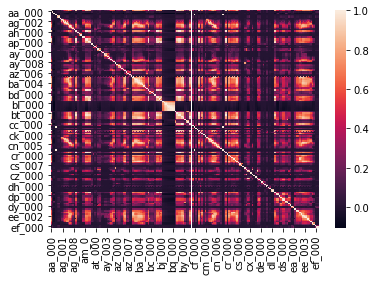

In [32]:
ax = sns.heatmap(corrMatrix)

### iv. Pick floor(sqrt(170)) features with highest CV, and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following quesitons. We picked them only for visualization.

In [36]:
#We should be choosing 13 features
#We need to show the 11 features with the highest cv
top_cv=cv.nlargest(13)
top_cv

cf_000    244.887517
co_000    244.507385
ad_000    244.322816
cs_009    237.930554
dh_000    123.216097
dj_000    117.494225
ag_000     92.917755
as_000     87.332500
ay_009     84.733735
ak_000     80.424975
az_009     77.838544
ch_000     77.453857
au_000     68.882751
dtype: float64

In [37]:
#Get the index values from top cv
top_cv_ind=list(top_cv.index.values)
plots_df=APS_train_X.loc[:,top_cv_ind]
plots_df = pd.concat([plots_df, APS_train_Y], axis=1)
plots_df.head()


,cf_000,co_000,ad_000,cs_009,dh_000,dj_000,ag_000,as_000,ay_009,ak_000,az_009,ch_000,au_000,class
0,2.0,220.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neg
1,2.0,8.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neg
2,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neg
3,2.0,2.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neg
4,0.0,202.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neg


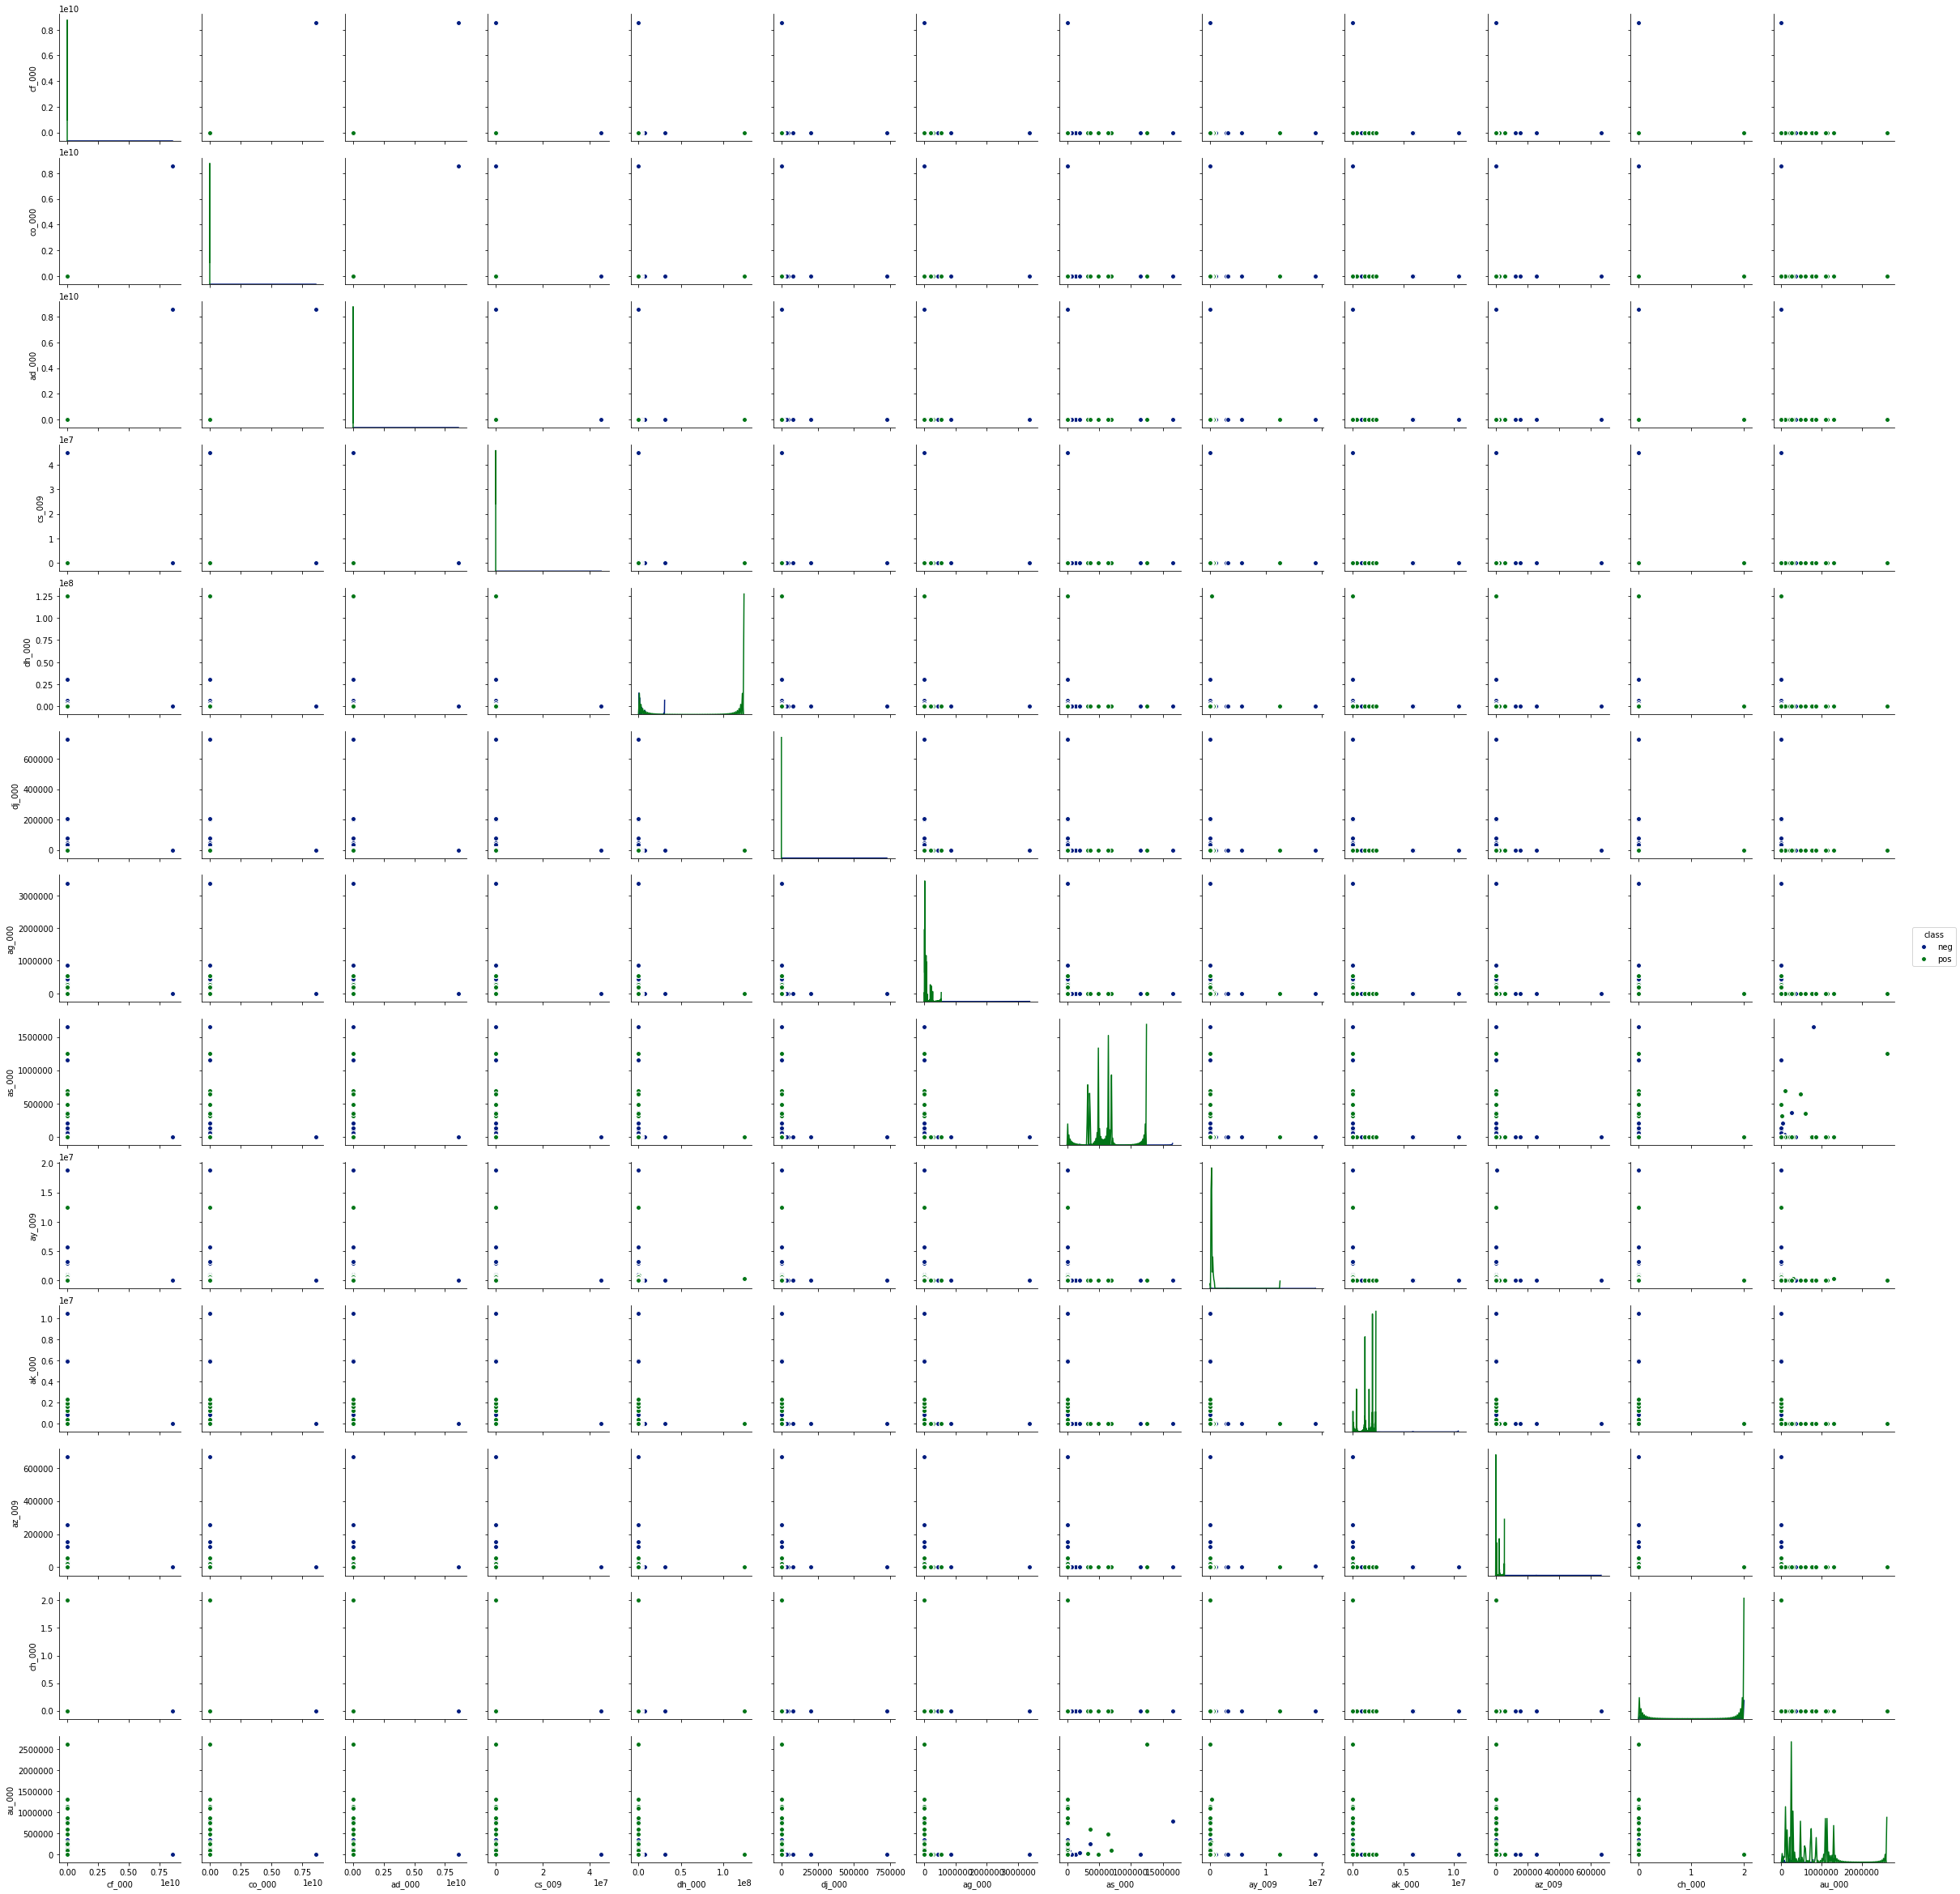

In [38]:
#Scatterplots
p = sns.pairplot(plots_df,
                diag_kind='kde',
                 palette='dark',
                hue='class')

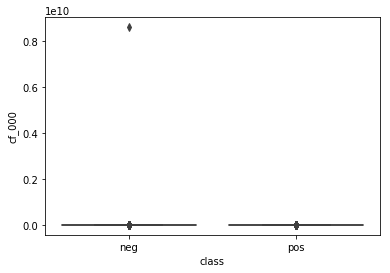

In [39]:
g_0=sns.boxplot(y=plots_df.iloc[:,0],
                x=plots_df['class'])

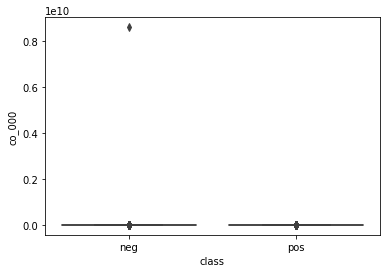

In [40]:
g_1=sns.boxplot(y=plots_df.iloc[:,1],
                x=plots_df['class'])

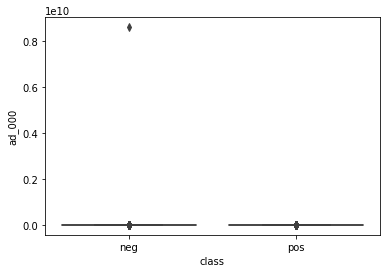

In [41]:
g_2=sns.boxplot(y=plots_df.iloc[:,2],
                x=plots_df['class'])

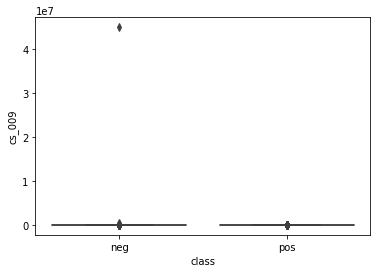

In [42]:
g_3=sns.boxplot(y=plots_df.iloc[:,3],
                x=plots_df['class'])

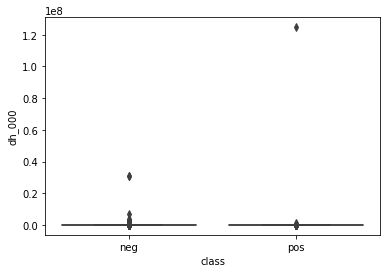

In [43]:
g_4=sns.boxplot(y=plots_df.iloc[:,4],
                x=plots_df['class'])

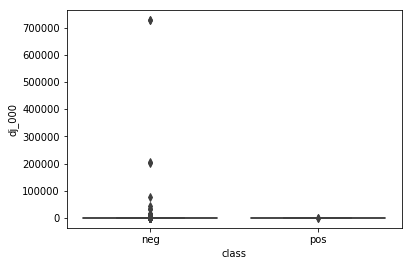

In [44]:
g_5=sns.boxplot(y=plots_df.iloc[:,5],
                x=plots_df['class'])

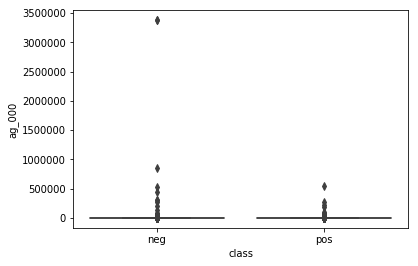

In [45]:
g_6=sns.boxplot(y=plots_df.iloc[:,6],
                x=plots_df['class'])

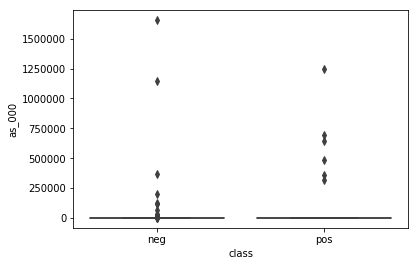

In [46]:
g_7=sns.boxplot(y=plots_df.iloc[:,7],
                x=plots_df['class'])

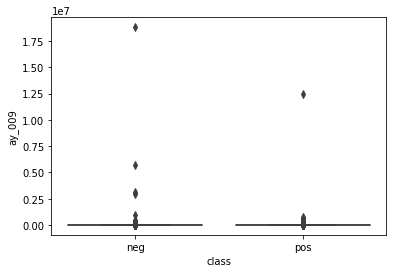

In [47]:
g_8=sns.boxplot(y=plots_df.iloc[:,8],
                x=plots_df['class'])

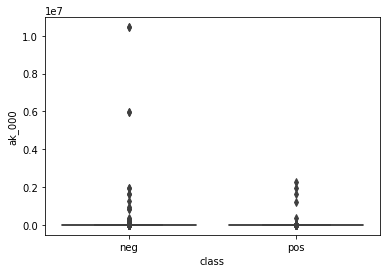

In [48]:
g_9=sns.boxplot(y=plots_df.iloc[:,9],
                x=plots_df['class'])

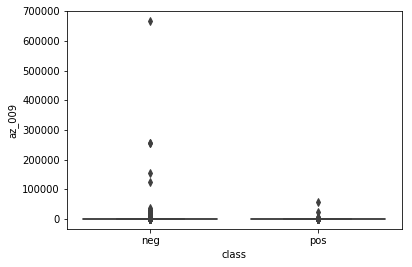

In [49]:
g_10=sns.boxplot(y=plots_df.iloc[:,10],
                x=plots_df['class'])

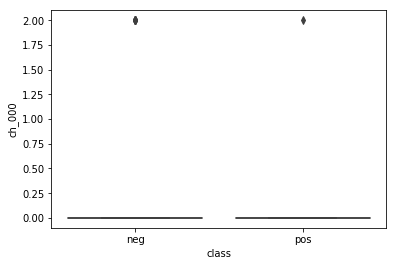

In [50]:
g_11=sns.boxplot(y=plots_df.iloc[:,11],
                x=plots_df['class'])

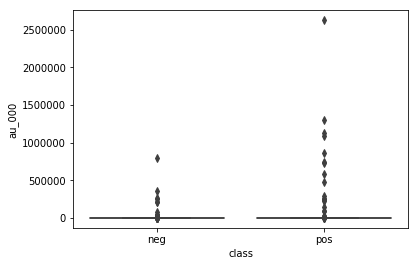

In [51]:
g_12=sns.boxplot(y=plots_df.iloc[:,12],
                x=plots_df['class'])

#### Answer: No, I can't draw conclusions about significance of hte features just by the scatterplots. There does not appear to be any clear separation between classes. This is especially difficult to determine with the small number of instances of the positive class. There appear to be a number of outliers in the scatterplots, this notion is confirmed by the boxplots of each of the variables.

### v. Determine the number of positive and negative data. Is this dataset imbalanced?

In [52]:
APS_train_Y.value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

#### Answer: There are 59,000 instances of the negative class and only 1,000 instances of the positive class. The positive class only makes up 1.7% of the observations, and therefore the dataset is imbalanced.

### (c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the dataset. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (you may use pROC package). Calculate Out of Bag error estimate for your random forest and compare it to the test error.

In [9]:
#Make the target labels 0 and 1
#1 is pos
#0 is neg

#Train
APS_train_Y=APS_train_Y.replace('pos',1)
APS_train_Y=APS_train_Y.replace('neg',0)

#Test
APS_test_Y=APS_test_Y.replace('pos',1)
APS_test_Y=APS_test_Y.replace('neg',0)


In [54]:
#https://www.datacamp.com/community/tutorials/random-forests-classifier-python
#Instantiate and train the random forest
forest=RandomForestClassifier(n_estimators=100, oob_score=True)
forest.fit(APS_train_X,APS_train_Y)


RandomForestClassifier(oob_score=True)

#### Training Confusion Matrix, ROC, AUC, and misclassification:

In [55]:
#Training Prediciton, Confusion MAtrix
train_pred=forest.predict(APS_train_X)
cmat=metrics.confusion_matrix(APS_train_Y, train_pred)
print('Training Confusion Matrix:\n',cmat)

Training Confusion Matrix:
 [[59000     0]
 [    0  1000]]


AUC: 1.0
ROC is plotted below:


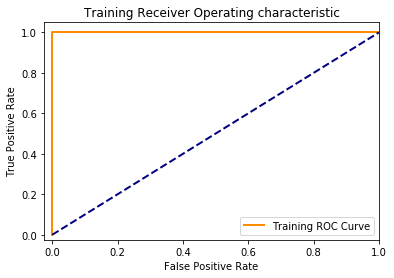

In [56]:
#Plot the ROC and AUC

probs = forest.predict_proba(APS_train_X)
probs = probs[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(APS_train_Y, probs)
auc=metrics.auc(fpr,tpr)
print('AUC:',auc)
print('ROC is plotted below:')

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Training ROC Curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.025, 1.0])
plt.ylim([-0.025, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training Receiver Operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [57]:
#Misclassification
train_err=1-metrics.accuracy_score(APS_train_Y, train_pred)
print('Training Misclassification:', train_err)

Training Misclassification: 0.0


#### Test Confusion Matrix, ROC, AUC, and misclassification:

In [58]:
#Test Prediciton, Confusion MAtrix
test_pred=forest.predict(APS_test_X)
cmat=metrics.confusion_matrix(APS_test_Y, test_pred)
print('Test Confusion Matrix:\n',cmat)

Test Confusion Matrix:
 [[15607    18]
 [  112   263]]


AUC: 0.991714816
ROC is plotted below:


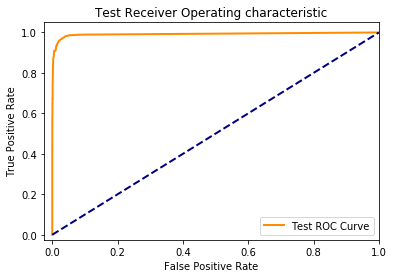

In [59]:
#Plot the ROC and AUC

probs = forest.predict_proba(APS_test_X)
probs = probs[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(APS_test_Y, probs)
auc=metrics.auc(fpr,tpr)
print('AUC:',auc)
print('ROC is plotted below:')

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Test ROC Curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.025, 1.0])
plt.ylim([-0.025, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Receiver Operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [60]:
#Misclassification
test_err=1-metrics.accuracy_score(APS_test_Y, test_pred)
print('Test Misclassification:', test_err)

Test Misclassification: 0.008125000000000049


In [61]:
#Out of Bag Error Estimate
#https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method
print('Out of Bag Error:',1-forest.oob_score_)

Our of Bag Error: 0.006316666666666637


#### The Out of Bag Error Rate was lower than the Test Error rate. However, it was only slightly lower, and both error rates are incredibly low. Test accuracy and OOB score are high.

### (d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 2c. Compare the results with those of 2c.

#### Answer: When using the RandomForestClassifier, we can include the setting class_weight=balanced in order to compensate for class imbalance. This makes classes weighted inversely proportional to how frequently they appear in the data. I found out about this via the following source:<br>
https://chrisalbon.com/machine_learning/trees_and_forests/handle_imbalanced_classes_in_random_forests/

In [86]:
#Try using 'balanced' and 'balanced_subsample'
forest2=RandomForestClassifier(random_state=0, n_jobs=-1, class_weight='balanced_subsample', oob_score=True)
forest2.fit(APS_train_X,APS_train_Y)

RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       oob_score=True, random_state=0)

#### Training Confusion Matrix, ROC, AUC, and misclassification:

In [87]:
#Training Prediciton, Confusion MAtrix
train_pred=forest2.predict(APS_train_X)
cmat=metrics.confusion_matrix(APS_train_Y, train_pred)
print('Training Confusion Matrix:\n',cmat)

Training Confusion Matrix:
 [[59000     0]
 [    0  1000]]


AUC: 1.0
ROC is plotted below:


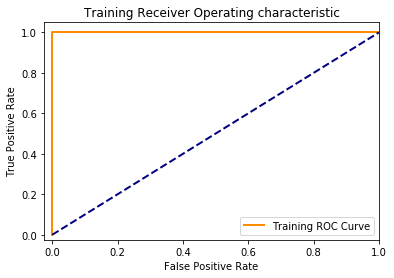

In [88]:
#Plot the ROC and AUC

probs = forest2.predict_proba(APS_train_X)
probs = probs[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(APS_train_Y, probs)
auc=metrics.auc(fpr,tpr)
print('AUC:',auc)
print('ROC is plotted below:')

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Training ROC Curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.025, 1.0])
plt.ylim([-0.025, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training Receiver Operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [89]:
#Misclassification
train_err=1-metrics.accuracy_score(APS_train_Y, train_pred)
print('Training Misclassification:', train_err)

Training Misclassification: 0.0


#### Test Confusion Matrix, ROC, AUC, and misclassification:

In [90]:
#Test Prediciton, Confusion MAtrix
test_pred=forest2.predict(APS_test_X)
cmat=metrics.confusion_matrix(APS_test_Y, test_pred)
print('Test Confusion Matrix:\n',cmat)

Test Confusion Matrix:
 [[15610    15]
 [  159   216]]


AUC: 0.991965184
ROC is plotted below:


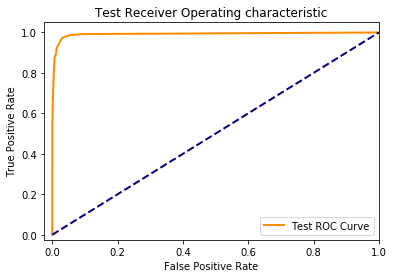

In [91]:
#Plot the ROC and AUC

probs = forest2.predict_proba(APS_test_X)
probs = probs[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(APS_test_Y, probs)
auc=metrics.auc(fpr,tpr)
print('AUC:',auc)
print('ROC is plotted below:')

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Test ROC Curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.025, 1.0])
plt.ylim([-0.025, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Receiver Operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [92]:
#Misclassification
test_err=1-metrics.accuracy_score(APS_test_Y, test_pred)
print('Test Misclassification:', test_err)

Test Misclassification: 0.010874999999999968


In [93]:
#Out of Bag Error Estimate
#https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method
print('Out of Bag Error:',1-forest2.oob_score_)

Out of Bag Error: 0.007650000000000046


#### My random forest performed worse after compensating for the class imbalance using class_weight='balanced' and 'balanced_subsample'. Test misclassification was larger than Out of Bag Error. OOB Error and test misclassification were worse for the random forest with class imbalance compensation than for the random forest where I didn't compensate.
#### As a result, I will see if using SMOTE before hand will perform better.

In [95]:
smo = SMOTE()
data, target = smo.fit_resample(APS_train_X, APS_train_Y)

forest3=RandomForestClassifier(n_estimators=100, oob_score=True)
forest3.fit(data,target)


RandomForestClassifier(oob_score=True)

#### Training Confusion Matrix, ROC, AUC, and misclassification:

In [96]:
#Training Prediciton, Confusion MAtrix
train_pred=forest3.predict(data)
cmat=metrics.confusion_matrix(target, train_pred)
print('Training Confusion Matrix:\n',cmat)

Training Confusion Matrix:
 [[59000     0]
 [    0 59000]]


AUC: 1.0
ROC is plotted below:


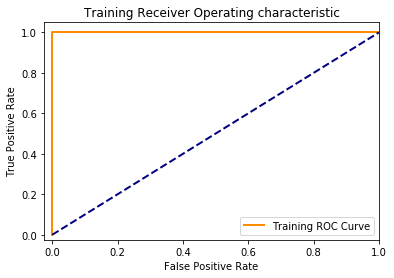

In [97]:
#Plot the ROC and AUC

probs = forest3.predict_proba(data)
probs = probs[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(target, probs)
auc=metrics.auc(fpr,tpr)
print('AUC:',auc)
print('ROC is plotted below:')

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Training ROC Curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.025, 1.0])
plt.ylim([-0.025, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training Receiver Operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [98]:
#Misclassification
train_err=1-metrics.accuracy_score(target, train_pred)
print('Training Misclassification:', train_err)

Training Misclassification: 0.0


#### Test Confusion Matrix, ROC, AUC, and misclassification:

In [99]:
#Test Prediciton, Confusion MAtrix
test_pred=forest3.predict(APS_test_X)
cmat=metrics.confusion_matrix(APS_test_Y, test_pred)
print('Test Confusion Matrix:\n',cmat)

Test Confusion Matrix:
 [[15546    79]
 [   60   315]]


AUC: 0.9945372159999999
ROC is plotted below:


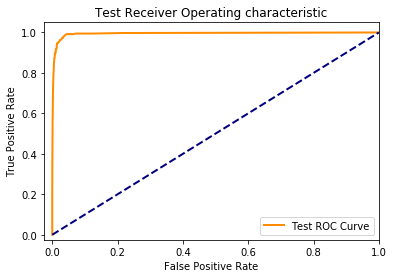

In [100]:
#Plot the ROC and AUC

probs = forest3.predict_proba(APS_test_X)
probs = probs[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(APS_test_Y, probs)
auc=metrics.auc(fpr,tpr)
print('AUC:',auc)
print('ROC is plotted below:')

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Test ROC Curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.025, 1.0])
plt.ylim([-0.025, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Receiver Operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [101]:
#Misclassification
test_err=1-metrics.accuracy_score(APS_test_Y, test_pred)
print('Test Misclassification:', test_err)

Test Misclassification: 0.00868749999999996


In [102]:
#Out of Bag Error Estimate
#https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method
print('Out of Bag Error:',1-forest3.oob_score_)

Out of Bag Error: 0.003237288135593208


#### After using SMOTE, Test Misclassification was very similar to that for the random forest where we did not compensate for imbalance. The OOB Error rate when we used sMOTE was much lower. The number of true positive classifications was higher however.

### (e) Model Trees
### In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classification trees, majority pollin is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used.....Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion MAtrix, ROC, and AUC for  training and test sets. 


In [54]:
#Train
APS_train_Y=APS_train_Y.replace(1,'pos')
APS_train_Y=APS_train_Y.replace(0,'neg')

#Test
APS_test_Y=APS_test_Y.replace(1,'pos')
APS_test_Y=APS_test_Y.replace(0,'neg')

In [ ]:
filename = os.path.join(fileDir, '../data/Homework4Data/weka_file.csv')
filename = os.path.abspath(os.path.realpath(filename))




d=pd.concat([APS_train_X,APS_train_Y], axis=1)
d.to_csv(filename, index=False, header=True)


jvm.start(packages=True)

data = conv.load_any_file(filename)
data.class_is_last()
classifier = Classifier(classname="weka.classifiers.trees.LMT")
evaluation = Evaluation(data)                     # initialize with priors
evaluation.crossvalidate_model(classifier, data, 5, Random(42))  # 5-fold CV
classifier.build_classifier(data)
train_evaluation=Evaluation(data)
train_evaluation.test_model(classifier, data)
print(train_evaluation.summary())
print("pctCorrect: " + str(train_evaluation.percent_correct))
print("incorrect: " + str(train_evaluation.incorrect))

jvm.stop()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Users/lukenelson/anaconda3/lib/python3.6/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Users/lukenelson/anaconda3/lib/python3.6/site-packages/javabridge/jars/runnablequeue.jar', '/Users/lukenelson/anaconda3/lib/python3.6/site-packages/javabridge/jars/cpython.jar', '/Users/lukenelson/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/lukenelson/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support enabled


DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Users/lukenelson/anaconda3/lib/python3.6/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Users/lukenelson/anaconda3/lib/python3.6/site-packages/javabridge/jars/runnablequeue.jar', '/Users/lukenelson/anaconda3/lib/python3.6/site-packages/javabridge/jars/cpython.jar', '/Users/lukenelson/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/lukenelson/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/Users/lukenelson/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/lukenelson/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/Users/lukenelson/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/lukenelson/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/Users/lukenelson/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/lukenelson/anaconda3/lib/python3.6/site-packages/we

=== Confusion Matrix ===

     a     b   <-- classified as
 74389   236 |     a = neg
   465   910 |     b = pos



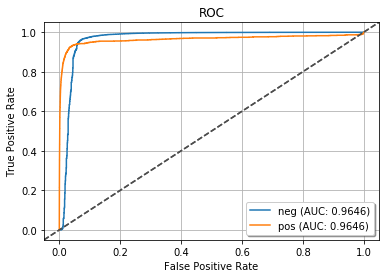

In [30]:
jvm.start(packages=True)
print(train_evaluation.matrix())
plcls.plot_roc(train_evaluation, class_index=[0,1],wait=True)
jvm.stop()

In [28]:
#Test
filename2 = os.path.join(fileDir, '../data/Homework4Data/weka_file_test.csv')
filename2 = os.path.abspath(os.path.realpath(filename2))


e=pd.concat([APS_test_X,APS_test_Y], axis=1)
e.to_csv(filename2, index=False, header=True)


jvm.start(packages=True)

test = conv.load_any_file(filename2)
test.class_is_last()

classifier = Classifier(classname="weka.classifiers.trees.LMT")
evaluation = Evaluation(data)                     # initialize with priors
evaluation.crossvalidate_model(classifier, data, 5, Random(42))  # 5-fold CV
classifier.build_classifier(data)


test_evaluation=Evaluation(test)
test_evaluation.test_model(classifier, test)
print(test_evaluation.summary())
print("pctCorrect: " + str(test_evaluation.percent_correct))
print("incorrect: " + str(test_evaluation.incorrect))

jvm.stop()
#Testmodel method
#Put the train classifier and then evaluate


INFO:weka.core.jvm:JVM already running, call jvm.stop() first



Correctly Classified Instances       75299               99.0776 %
Incorrectly Classified Instances       701                0.9224 %
Kappa statistic                          0.7173
Mean absolute error                      0.0125
Root mean squared error                  0.0861
Relative absolute error                 35.2847 %
Root relative squared error             64.6147 %
Total Number of Instances            76000     

pctCorrect: 99.07763157894736
incorrect: 701.0
=== Confusion Matrix ===

     a     b   <-- classified as
 74389   236 |     a = neg
   465   910 |     b = pos



In [ ]:
jvm.start(packages=True)
print(test_evaluation.matrix())
plcls.plot_roc(test_evaluation, class_index=[0,1],wait=True)
jvm.stop()

### (f) Use SMOTE to pre-process your data to compensate for class imbalance. Train a Logistic Model Tree using the pre-processed data and repeat 2e. Do not forget that there is a right and wrong way of cross validation here. Compare the uncompensated case with SMOTE.

In [1]:
#Cross Fold

skf = StratifiedKFold(n_splits=5)

rats=0
for train_index, val_index in skf.split(APS_train_X, APS_train_Y):

    X_train, X_val = APS_train_X.iloc[train_index], APS_train_X.iloc[val_index]
    y_train, y_val = APS_train_Y.iloc[train_index], APS_train_Y.iloc[val_index]

    smo=SMOTE()
    X_train, y_train = smo.fit_resample(X_train, y_train)
    
    filename3 = os.path.join(fileDir, '../data/Homework4Data/weka_file_cv'+str(rats)+'.csv')
    filename3 = os.path.abspath(os.path.realpath(filename3))
    
    filename4 = os.path.join(fileDir, '../data/Homework4Data/weka_file_cvval'+str(rats)+'.csv')
    filename4 = os.path.abspath(os.path.realpath(filename4))
    
    rats=rats+1
    
    f=pd.concat([X_train,y_train], axis=1)
    f.to_csv(filename3, index=False, header=True)
    
    f2=pd.concat([X_val,y_val], axis=1)
    f2.to_csv(filename4, index=False, header=True)
    
    jvm.start(packages=True)

    trainf = conv.load_any_file(filename3)
    trainf.class_is_last()

    cls = Classifier(classname="weka.classifiers.trees.LMT")
    cls.build_classifier(trainf)
    train_evaluation=Evaluation(trainf)
    train_evaluation.test_model(cls, trainf)
    print(train_evaluation.summary())
    print("pctCorrect: " + str(train_evaluation.percent_correct))
    print("incorrect: " + str(train_evaluation.incorrect))
    print(train_evaluation.matrix())
    print(plcls.plot_roc(train_evaluation, class_index=[0,1],wait=True))
    
    testf = conv.load_any_file(filename4)
    testf.class_is_last()
    test_evaluation=Evaluation(testf)
    test_evaluation.test_model(cls, testf)
    print(test_evaluation.summary())
    print("pctCorrect: " + str(test_evaluation.percent_correct))
    print("incorrect: " + str(test_evaluation.incorrect))
    print(test_evaluation.matrix())
    print(plcls.plot_roc(test_evaluation, class_index=[0,1],wait=True))
    
    
    jvm.stop()
    
    
    

NameError: name 'StratifiedKFold' is not defined

#### Answer: Using SMOTE resulted in slightly better performance than the uncompensated case. From a computational standpoint, it took much longer for SMOTE to run so you could argue that there is a bit of a tradeoff between efficiency and accuracy in this case.

pandas.core.series.Series

### ISLR 6.8.3

### (a) As we increase s from 0, the training RSS will:

#### Answer: Steadily Decrease. As we increase s from 0, then we will have coeeficients for the betas, and those coefficients will increase to their least squares estimates. As s increases, the model becomes more flexible, and RSS decreases.

### (b) Repeat (a) for test RSS.

#### Answer: Decrease initially, and then eventually start increasing in a U shape. When s=0, then all betas are 0, and the test RSS is large as a result of the simplicity of the model. As s increases and we start to see coefficients for the betas, the model will begin to fit the test data better and RSS will go down. As s continues to increase, the model becomes extremely flexible and overfits the training data. Thus, at this point, the test RSS will begin to increase as a result of the model fitting too closely to the training data and performing poorly on the test data.

### (c) Repeat (a) for variance.

#### Answer: Steadily increase. As model flexibility increases, so does variance. When s=0, the model is essentially a constant and there is no variance as the model is very simpl.e As Betas begin to get coefficients and those coefficients begin to grow, then the model becomes more flexible and the variance increases. 

### (d) Repeat (a) for (squared) bias.

#### Answer: Stedily decrease. Bias results from trying simplify a real world problem. When s is 0, the model is effectivley a constant and very simple (not flexibile), so the variance will be very large. As s increases and the betas coefficients grow, the model becomes more flexible and thus the bias decreases.

### (e) Repeat (a) for the irreducible error.

#### ANswer: Remain Constant. Irreducible error by definition is independent of the model, and thus independent of the values of beta and s. Thus, changing s will have no affect on the irreducible error.

### ISLR 6.8.5


![](islr_6.8.5.jpg)

### ISLR 8.4.5

In [11]:
probs=[0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75]

In [12]:
#Majority vote approach:
Green_count=0
Red_count=0
for i in probs:
    if i >= 0.5:
        Red_count=Red_count+1
    else:
        Green_count=Green_count+1
print('Red Count:',Red_count)
print('Green Count:',Green_count)

Red Count: 6
Green Count: 4


In [13]:
#Average Probability approach
sum(probs)/len(probs)

0.45

#### Answer: Under the majority vote approach, the final classification is Red. This is because Red was the most commonly occuring class among the 10 predictors (We saw 6 for Red and 4 for Green). <br>Under the average probability approach, the final classification is Green, as a result of the probability being below 50% (the probability is 45%).

### ISLR 9.7.3
### (a) We are given n=7 observations in p=2 dimensions. For each observation, there is an associated class label. Sketch the observations.

Text(0,0.5,'X2')

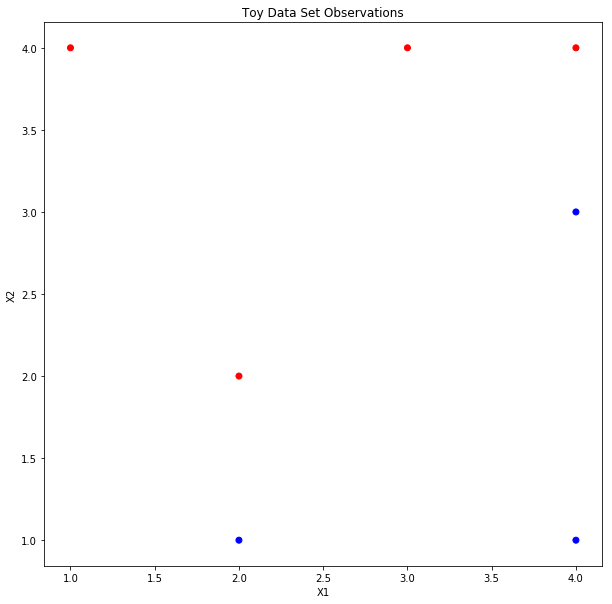

In [18]:
import matplotlib.pyplot as plt

x=[[3, 2, 4, 1, 2, 4, 4],[4, 2, 4, 4, 1, 3, 1]]
y=['r', 'r', 'r', 'r', 'b', 'b', 'b']

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.scatter(x[0], x[1], c=y)
plt.title('Toy Data Set Observations')
plt.xlabel('X1')
plt.ylabel('X2')


### (b) Sketch the optimal separating hyperplane, and provide the equation for this hyperplane (of the form (9.1)).

In [15]:
xs=[0,1,2,3,4,5]
ys=list()
for i in xs:
    y=i-.5
    ys.append(y)
    
ys

[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]

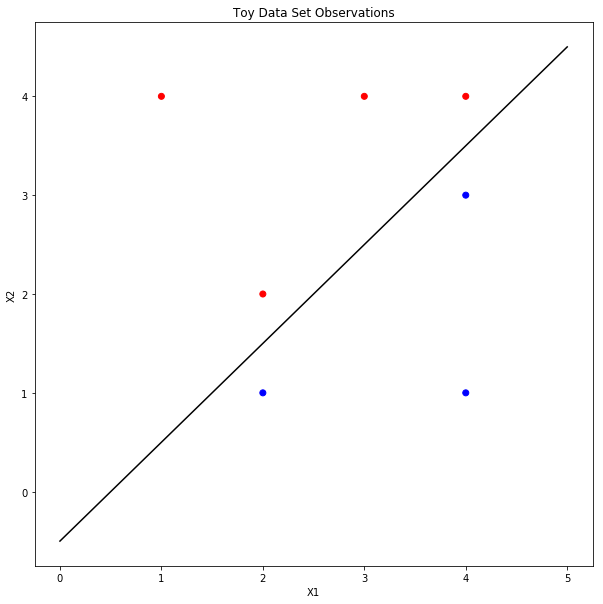

In [19]:
from sklearn import svm
import numpy as np
x=[[3, 2, 4, 1, 2, 4, 4],[4, 2, 4, 4, 1, 3, 1]]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.scatter(x[0], x[1], c=y)
plt.title('Toy Data Set Observations')
plt.xlabel('X1')
plt.ylabel('X2')

plt.plot(xs, ys, 'k-')

#### The equation of this hyperplane is calculated as follows: 0.5-X1+X2=0<br> My method for arriving at this is as follows: (What looks like x^2 below in the third line is actually x_2. and in the same equation, 1x is 1x_1.

![](islr_9.7.3_b.jpg)

### (c) Describe the classification rule for the maximal margin classifier. It should be something along the lines of ....Provide the values for B0, B1, and B2.

#### Answer: Classify to Blue if x1 - x2 - 0.5 > 0, and classify to Red otherwise. Beta_0 = -0.5, beta_1=1, beta_2=-1

### (d) On your sketch, indicate the margin for the maximal margin hyperplane.

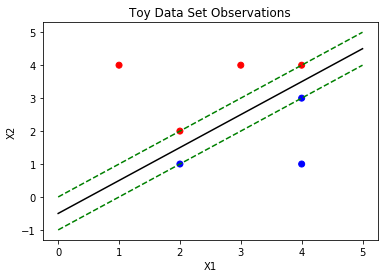

In [20]:
y1s=list()
y2s=list()
for i in xs:
    y1=i-1
    y2=i
    y1s.append(y1)
    y2s.append(y2)

    #fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(111)
plt.scatter(x[0], x[1], c=y)
plt.title('Toy Data Set Observations')
plt.xlabel('X1')
plt.ylabel('X2')

plt.plot(xs, ys, 'k-')
plt.plot(xs, y1s, 'g--')
plt.plot(xs, y2s, 'g--')

### (e) Indicate the support vectors for the maximal margin classifier.

#### Answer: The support vectors are the points (2,1), (2,2), (4,3) and (4,4).

### (f) Argue that a slight movement of the seventh observation would not affect the maximal margin hyperplane.

#### Answer: Only observations that either lie on the margin or that violate the margin will affect the hyperplane. Thus, an observation that lies strictly on the correct side of the margin does not affect the support vector classifier. The 7th observation lies outside of the margin and thus would not affect the hyperplane.

### (g) Sketch a hyperpane that is not the optimal separating hyperplane, and provide the equation for this hyperplane.

#### Answer: The hyperplane with the equation X1-X2-0.3=0 is an example of a hyperplane that is not the optimal hyperplane. Here is a sketch of it:

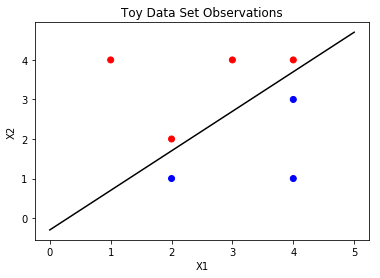

In [21]:
xs=[0,1,2,3,4,5]
ws=list()
for i in xs:
    w=i-.3
    ws.append(w)


#fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(111)
plt.scatter(x[0], x[1], c=y)
plt.title('Toy Data Set Observations')
plt.xlabel('X1')
plt.ylabel('X2')

plt.plot(xs, ws, 'k-')

### (h) Draw an additional observation on the plot so that the two classes are no longer separable by a hyperplane.

Text(0,0.5,'X2')

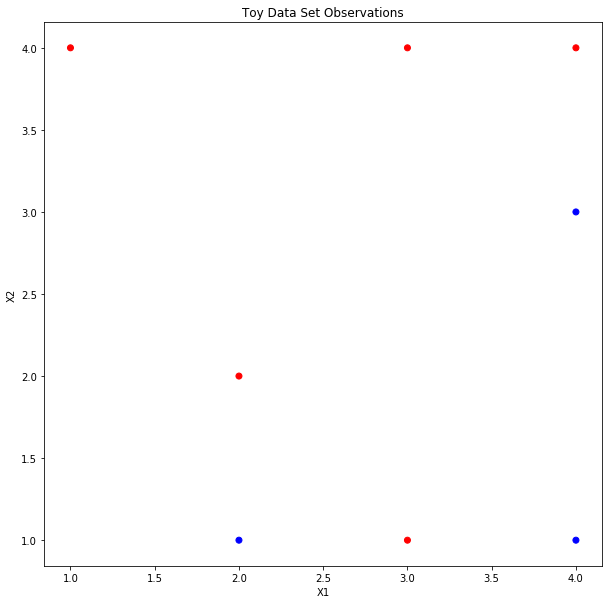

In [22]:
x=[[3, 2, 4, 1, 2, 4, 4,3],[4, 2, 4, 4, 1, 3, 1,1]]
y=['r', 'r', 'r', 'r', 'b', 'b', 'b','r']

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.scatter(x[0], x[1], c=y)
plt.title('Toy Data Set Observations')
plt.xlabel('X1')
plt.ylabel('X2')